In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle

In [149]:
data = pd.read_csv('train.csv')

In [150]:
#Drop na's.
#Since the number of missing values are about 1%,taking an 'executive decision' of removing them.  
data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)
data_test.dropna(axis=0, inplace=True) #remove all rows with na's.
data_test.reset_index(drop=True)

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
5,5,2018-01-06,1,1
6,6,2018-01-07,1,1
7,7,2018-01-08,1,1
8,8,2018-01-09,1,1
9,9,2018-01-10,1,1


In [352]:
#calculate average sales for each iteam for each day 
data_gp = data_train.sort_values('date').groupby(['item', 'date'], as_index=False)
data_gp = data_gp.agg({'sales':['mean']})
data_gp.columns = ['item', 'date', 'sales']
data_gp.head()

,item,date,sales
0,1,2013-01-01,13.3
1,1,2013-01-02,9.9
2,1,2013-01-03,12.7
3,1,2013-01-04,14.5
4,1,2013-01-05,14.9


In [410]:
#item_1_train_dataset
item_1_data =  data_gp.loc[(train_gp['item']==1),["sales"]].values
item_1_data = item_1_data.astype("float32")
#item_2_train_dataset
item_2_data =  data_gp.loc[(train_gp['item']==2),["sales"]].values
item_2_data = item_2_data.astype("float32")
#item_2_train_dataset
item_3_data =  data_gp.loc[(train_gp['item']==3),["sales"]].values
item_3_data = item_3_data.astype("float32")

print(item_3_data.size,item_2_data.size,item_3_data.size)

1826 1826 1826


In [411]:
#since the data ranges from 2013-01-01 to 2017-12-31 take last year as test dataset
train_item_1 = item_1_data[:-365]
test_item_1 = item_1_data[-365:]
train_item_2 = item_2_data[:-365]
test_item_2 = item_2_data[-365:]
train_item_3 = item_3_data[:-365]
test_item_3 = item_3_data[-365:]

print("train size: {}, test size: {}".format(len(train_item_1), len(test_item_1)))

train size: 1461, test size: 365


In [412]:
#transform the data using minmax scaler
scaler_1 = MinMaxScaler(feature_range=(0,1))
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_3 = MinMaxScaler(feature_range=(0,1))

train_item_1 = scaler.fit_transform(train_item_1)
test_item_1 = scaler.transform(test_item_1)

train_item_2 = scaler_2.fit_transform(train_item_2)
test_item_2 = scaler_2.transform(test_item_2)

train_item_3 = scaler_3.fit_transform(train_item_3)
test_item_3 = scaler_3.transform(test_item_3)

In [413]:
#train:

time_step = 30
datax_item_1=[]
datay_item_1=[]

for i in range(len(train_item_1)-time_step-1):
    datax_item_1.append(train_item_1[i:(i+time_step),0])
    datay_item_1.append(train_item_1[i+time_step,0])
trainx_item_1=np.array(datax_item_1)
trainy_item_1=np.array(datay_item_1)

datax_item_2=[]
datay_item_2=[]

for i in range(len(train_item_2)-time_step-1):
    datax_item_2.append(train_item_2[i:(i+time_step),0])
    datay_item_2.append(train_item_2[i+time_step,0])
trainx_item_2=np.array(datax_item_2)
trainy_item_2=np.array(datay_item_2)

datax_item_3=[]
datay_item_3=[]

for i in range(len(train_item_3)-time_step-1):
    datax_item_3.append(train_item_3[i:(i+time_step),0])
    datay_item_3.append(train_item_3[i+time_step,0])
trainx_item_3=np.array(datax_item_3)
trainy_item_3=np.array(datay_item_3)

In [414]:
#test:

datax_item_1=[]
datay_item_1=[]

for i in range(len(test_item_1)-time_step-1):
    datax_item_1.append(test_item_1[i:(i+time_step),0])
    datay_item_1.append(test_item_1[i+time_step,0])
testx_item_1=np.array(datax_item_1)
testy_item_1=np.array(datay_item_1)


datax_item_2=[]
datay_item_2=[]

for i in range(len(test_item_2)-time_step-1):
    datax_item_2.append(test_item_2[i:(i+time_step),0])
    datay_item_2.append(test_item_2[i+time_step,0])
testx_item_2=np.array(datax_item_2)
testy_item_2=np.array(datay_item_2)

datax_item_3=[]
datay_item_3=[]

for i in range(len(test_item_3)-time_step-1):
    datax_item_3.append(test_item_3[i:(i+time_step),0])
    datay_item_3.append(test_item_3[i+time_step,0])
testx_item_3=np.array(datax_item_3)
testy_item_3=np.array(datay_item_3)

In [415]:
trainx_item_1=np.reshape(trainx_item_1, (trainx_item_1.shape[0],1,trainx_item_1.shape[1]))
testx_item_1=np.reshape(testx_item_1, (testx_item_1.shape[0],1,testx_item_1.shape[1]))

trainx_item_2=np.reshape(trainx_item_2, (trainx_item_2.shape[0],1,trainx_item_2.shape[1]))
testx_item_2=np.reshape(testx_item_2, (testx_item_2.shape[0],1,testx_item_2.shape[1]))

trainx_item_3=np.reshape(trainx_item_3, (trainx_item_3.shape[0],1,trainx_item_3.shape[1]))
testx_item_3=np.reshape(testx_item_3, (testx_item_3.shape[0],1,testx_item_3.shape[1]))


In [416]:
model =Sequential()
model.add(LSTM(5, input_shape=(1, time_step))) #5 LSTM neuron
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainx_item_1, trainy_item_1, epochs=20, batch_size=32,    validation_split=0.1, shuffle=False)

Epoch 1/20
41/41 [==============================] - 1s 16ms/step - loss: 0.0334 - val_loss: 0.0154
Epoch 2/20
41/41 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 3/20
41/41 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 4/20
41/41 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 5/20
41/41 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.0085
Epoch 6/20
41/41 [==============================] - 0s 7ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 7/20
41/41 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0078
Epoch 8/20
41/41 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 9/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 10/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 11/20
41/41 

In [417]:
model_2 =Sequential()
model_2.add(LSTM(5, input_shape=(1, time_step))) #5 LSTM neuron
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')
history_2 = model.fit(trainx_item_2, trainy_item_2, epochs=20, batch_size=32,   validation_split=0.1, shuffle=False)

Epoch 1/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 2/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 3/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 4/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 5/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 6/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 7/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 8/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 9/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 10/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 11/20
41/41 [

In [418]:
model_3 =Sequential()
model_3.add(LSTM(5, input_shape=(1, time_step))) #5 LSTM neuron
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')
history_3 = model.fit(trainx_item_3, trainy_item_3, epochs=20, batch_size=32,  validation_split=0.1, shuffle=False) 

Epoch 1/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 2/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 3/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 4/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 5/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 6/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 7/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 8/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 9/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 10/20
41/41 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 11/20
41/41 [

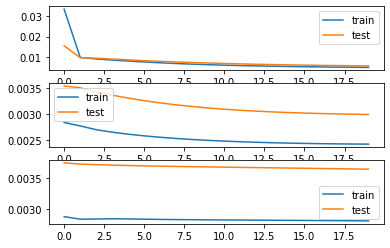

In [419]:
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 2)
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 3)
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend();

In [420]:
trainy_item_1 = trainy_item_1.reshape(1,-1)
testy_item_1 = testy_item_1.reshape(1,-1)

trainy_item_2 = trainy_item_2.reshape(1,-1)
testy_item_2 = testy_item_2.reshape(1,-1)

trainy_item_3 = trainy_item_3.reshape(1,-1)
testy_item_3 = testy_item_3.reshape(1,-1)

In [421]:
testPredict_item_1 = model.predict(testx_item_1)
testPredict_item_1 = scaler.inverse_transform(testPredict_item_1)
testy_item_1 = scaler.inverse_transform(testy_item_1)
trainPredict_item_1 = model.predict(trainx_item_1)
trainPredict_item_1 = scaler.inverse_transform(trainx_item_1)
trainy_item_1 = scaler.inverse_transform(trainy_item_1)

testPredict_item_2 = model.predict(testx_item_2)
trainPredict_item_2 = model.predict(trainx_item_2)
trainPredict_item_1 = scaler.inverse_transform(trainx_item_1)
testPredict_item_2 = scaler.inverse_transform(testPredict_item_2)
testy_item_2 = scaler.inverse_transform(testy_item_2)
trainy_item_2 = scaler.inverse_transform(trainy_item_2)

testPredict_item_3 = model.predict(testx_item_3)
trainPredict_item_3 = model.predict(trainx_item_3)
trainPredict_item_1 = scaler.inverse_transform(trainx_item_1)
testPredict_item_3 = scaler.inverse_transform(testPredict_item_3)
testy_item_3 = scaler.inverse_transform(testy_item_3)
trainy_item_3 = scaler.inverse_transform(trainy_item_3)

<Figure size 432x288 with 0 Axes>

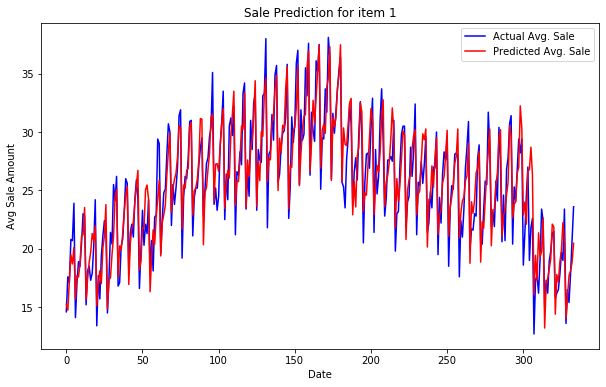

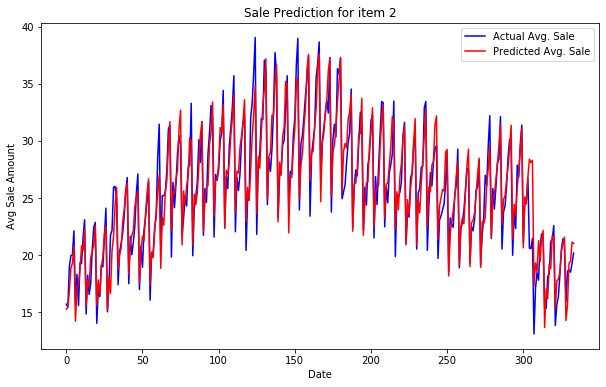

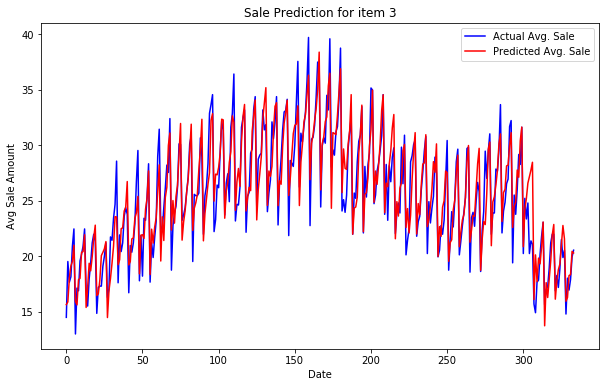

In [422]:
fig = plt.figure()
plt.figure(figsize=(10,6))
plt.plot(testy_item_1[0], color='blue', label='Actual Avg. Sale')
plt.plot(testPredict_item_1 , color='red', label='Predicted Avg. Sale')
plt.title('Sale Prediction for item 1')
plt.xlabel('Date')
plt.ylabel('Avg Sale Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_item_2[0], color='blue', label='Actual Avg. Sale')
plt.plot(testPredict_item_2 , color='red', label='Predicted Avg. Sale')
plt.title('Sale Prediction for item 2')
plt.xlabel('Date')
plt.ylabel('Avg Sale Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_item_3[0], color='blue', label='Actual Avg. Sale')
plt.plot(testPredict_item_3 , color='red', label='Predicted Avg. Sale')
plt.title('Sale Prediction for item 3')
plt.xlabel('Date')
plt.ylabel('Avg Sale Amount')
plt.legend()
plt.show()

In [423]:
trainscore = math.sqrt(mean_squared_error(trainy_item_1[0], trainPredict_item_1[:,0]))
testscore = math.sqrt(mean_squared_error(testy_item_1[0], testPredict_item_1[:,0]))
print("Train MSE for item 1 model : {}, Test MSE: {}".format(trainscore, testscore))

trainscore = math.sqrt(mean_squared_error(trainy_item_2[0], trainPredict_item_2[:,0]))
testscore = math.sqrt(mean_squared_error(testy_item_2[0], testPredict_item_2[:,0]))
print("Train MSE for item 2 model : {}, Test MSE: {}".format(trainscore, testscore))

trainscore = math.sqrt(mean_squared_error(trainy_item_3[0], trainPredict_item_3[:,0]))
testscore = math.sqrt(mean_squared_error(testy_item_3[0], testPredict_item_3[:,0]))
print("Train MSE for item 3 model : {}, Test MSE: {}".format(trainscore, testscore))

Train MSE for item 1 model : 21.680824857553418, Test MSE: 2.0230335436240128
Train MSE for item 2 model : 21.682033234582658, Test MSE: 1.6761730242982835
Train MSE for item 3 model : 21.648824456348592, Test MSE: 1.9548094542931784


In [426]:
print(trainy_item_2[0], trainPredict_item_2[:,0])

[12.639667 13.067522 15.868034 ... 15.517969 18.318487 18.629652] [0.16561814 0.1903872  0.22469549 ... 0.27514037 0.26969624 0.33527374]


# Predicting 90 days of 2018

In [449]:
#use sales of last 30 days of 2017 to predict next 90 days

#item1
testPredict_item_1_90 = []

x_data_item_1 = testx_item_1[-1] #get transformed sales values of last 30 days 
x_item_1 = np.reshape(x_data_item_1,(1,1,30))
yhat= model.predict(x_item_1)
testPredict_item_1_90= np.append(testPredict_item_1_90,scaler.inverse_transform(yhat))
x_data_item_1 = np.append(x_data_item_1,yhat)

for i in range (89):
        x_data_item_1 = x_data_item_1[1:]
        x_item_1 = np.reshape(x_data_item_1,(1,1,30))
        yhat= model.predict(x_item_1)
        testPredict_item_1_90= np.append(testPredict_item_1_90,scaler.inverse_transform(yhat))
        x_data_item_1 = np.append(x_data_item_1,yhat)
        
#item2     
testPredict_item_2_90 = []

x_data_item_2 = testx_item_2[-1] #get transformed sales values of last 30 days 
x_item_2 = np.reshape(x_data_item_2,(1,1,30))
yhat= model.predict(x_item_2)
testPredict_item_2_90= np.append(testPredict_item_2_90,scaler.inverse_transform(yhat))
x_data_item_2 = np.append(x_data_item_2,yhat)

for i in range (89):
        x_data_item_2 = x_data_item_2[1:]
        x_item_2 = np.reshape(x_data_item_2,(1,1,30))
        yhat= model.predict(x_item_2)
        testPredict_item_2_90= np.append(testPredict_item_2_90,scaler.inverse_transform(yhat))
        x_data_item_2 = np.append(x_data_item_2,yhat)
        
#item3
testPredict_item_3_90 = []

x_data_item_3 = testx_item_3[-1] #get transformed sales values of last 30 days 
x_item_3 = np.reshape(x_data_item_3,(1,1,30))
yhat= model.predict(x_item_3)
testPredict_item_3_90= np.append(testPredict_item_3_90,scaler.inverse_transform(yhat))
x_data_item_3 = np.append(x_data_item_3,yhat)

for i in range (89):
        x_data_item_3 = x_data_item_3[1:]
        x_item_3 = np.reshape(x_data_item_3,(1,1,30))
        yhat= model.predict(x_item_3)
        testPredict_item_3_90= np.append(testPredict_item_3_90,scaler.inverse_transform(yhat))
        x_data_item_3 = np.append(x_data_item_3,yhat)
        


In [462]:
#Create Dataframe with predicted sale values
item_1_test_df = pd.DataFrame(columns = ['date','item','pred_avg_sale'])
item_1_test_df['date']=pd.date_range(start='1/1/2018' ,end = '31/3/2018', freq='D')
item_1_test_df['item'] = 1
item_1_test_df['pred_avg_sale'] = testPredict_item_1_90

#Create Dataframe with predicted sale values
item_2_test_df = pd.DataFrame(columns = ['date','item','pred_avg_sale'])
item_2_test_df['date']=pd.date_range(start='1/1/2018' ,end = '31/3/2018', freq='D')
item_2_test_df['item'] = 2
item_2_test_df['pred_avg_sale'] = testPredict_item_3_90

#Create Dataframe with predicted sale values
item_3_test_df = pd.DataFrame(columns = ['date','item','pred_avg_sale'])
item_3_test_df['date']=pd.date_range(start='1/1/2018' ,end = '31/3/2018', freq='D')
item_3_test_df['item'] = 3
item_3_test_df['pred_avg_sale'] = testPredict_item_3_90

test_df = pd.concat([item_1_test_df , item_2_test_df, item_3_test_df],ignore_index=True)
test_df

,date,item,pred_avg_sale
0,2018-01-01,1,20.470173
1,2018-01-02,1,21.696228
2,2018-01-03,1,14.933059
3,2018-01-04,1,16.807880
4,2018-01-05,1,16.532318
5,2018-01-06,1,17.530090
6,2018-01-07,1,19.958508
7,2018-01-08,1,21.460812
8,2018-01-09,1,22.530987
9,2018-01-10,1,15.081951


In [464]:
test_df.to_csv('90_day_prediction.csv',index=False)